In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
import pymc as pm
import arviz as az

# 13. Pumps*

Adapted from [Unit 5: pumpsmc.m](https://raw.githubusercontent.com/areding/6420-pymc/main/original_examples/Codes4Unit5/pumpsmc.m) and [pumpsbugs.odc](https://raw.githubusercontent.com/areding/6420-pymc/main/original_examples/Codes4Unit5/pumpsbugs.odc).

Original sources: {cite:t}`conjugatelikelihoods1993` and {cite:t}`gaverpoisson`.

In [2]:
rng = np.random.default_rng(1)

obs = 100000
burn = 1000

# data from Gaver and O'Muircheartaigh, 1987
X = np.array([5, 1, 5, 14, 3, 19, 1, 1, 4, 22])
t = np.array([94.32, 15.52, 62.88, 125.76, 5.24, 31.44, 1.048, 1.048, 2.096, 10.48])
n = len(X)

# params
c = 0.1
d = 1

# inits
theta = np.ones(n)
beta = 1

thetas = np.zeros((obs, 10))
betas = np.zeros(obs)

for i in tqdm(range(obs)):
    theta = rng.gamma(shape=X + 1, scale=1 / (beta + t), size=n)
    sum_theta = np.sum(theta)

    beta = rng.gamma(shape=n + c, scale=1 / (sum_theta + d))

    thetas[i] = theta
    betas[i] = beta

thetas = thetas[burn:]
betas = betas[burn:]

  0%|          | 0/100000 [00:00<?, ?it/s]

means:
θ_1 : 0.0628
θ_2 : 0.1184
θ_3 : 0.0934
θ_4 : 0.1180
θ_5 : 0.6104
θ_6 : 0.6105
θ_7 : 0.8710
θ_8 : 0.8710
θ_9 : 1.4827
θ_10 : 1.9496
β: 1.3367


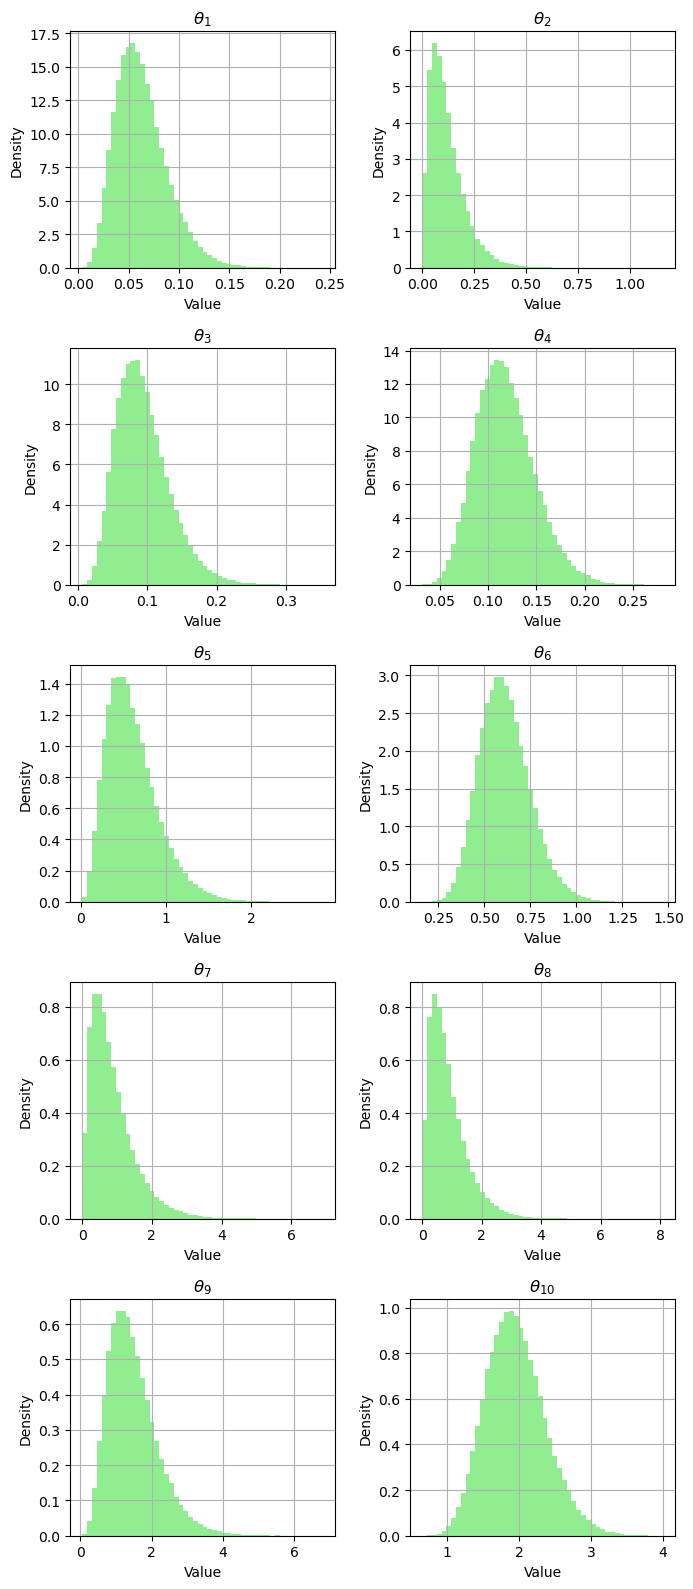

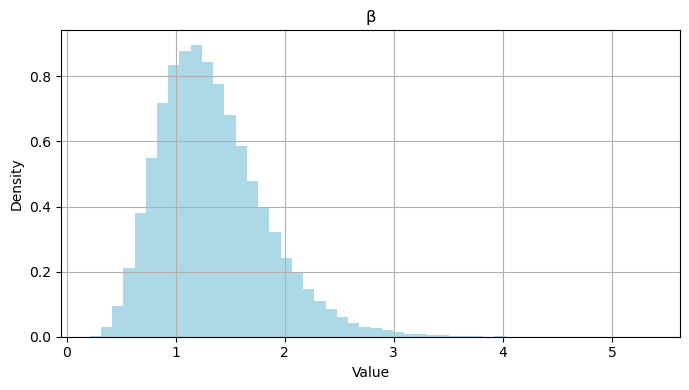

In [15]:
mean_thetas = np.mean(thetas, axis=0)
mean_betas = np.mean(betas)

print("means:")
for i, avg in enumerate(mean_thetas):
    print(f"θ_{i+1} : {avg:.4f}")

print(f"β: {mean_betas:.4f}")

# Create histograms for thetas
fig, axes = plt.subplots(5, 2, figsize=(7, 16))

for i, ax in enumerate(axes.flatten()):
    ax.grid(True)
    ax.hist(thetas[:, i], color="lightgreen", density=True, bins=50)
    ax.set_title(r"$\theta_{" + f"{i+1}" + r"}$")
    ax.set_xlabel(f"Value")
    ax.set_ylabel(f"Density")

plt.tight_layout()

# Create a histogram for beta
fig2, ax2 = plt.subplots(1, 1, figsize=(7, 4))

ax2.grid(True)
ax2.hist(betas, color="lightblue", density=True, bins=50)
ax2.set_title("β")
ax2.set_xlabel("Value")
ax2.set_ylabel("Density")

plt.tight_layout()
plt.show()

Now for the PyMC model:

In [4]:
with pm.Model() as m:
    times = pm.ConstantData("times", t)
    data = pm.ConstantData("data", X)

    beta = pm.Gamma("beta", alpha=c, beta=d)
    theta = pm.Gamma("theta", alpha=d, beta=beta, shape=n)
    rate = pm.Deterministic("rate", theta * times)

    likelihood = pm.Poisson("likelihood", mu=rate, observed=data)

    # start sampling
    trace = pm.sample(5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, theta]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 3 seconds.


In [5]:
az.summary(trace, var_names=["~rate"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta,1.336,0.489,0.496,2.235,0.003,0.002,28254.0,16048.0,1.0
theta[0],0.063,0.026,0.020,0.112,0.000,0.000,32410.0,13799.0,1.0
theta[1],0.118,0.083,0.005,0.270,0.000,0.000,29059.0,13169.0,1.0
theta[2],0.093,0.038,0.028,0.163,0.000,0.000,33616.0,12846.0,1.0
theta[3],0.118,0.030,0.064,0.176,0.000,0.000,32213.0,13436.0,1.0
theta[4],0.615,0.309,0.129,1.195,0.002,0.001,31105.0,12634.0,1.0
theta[5],0.610,0.134,0.368,0.866,0.001,0.001,35250.0,15216.0,1.0
theta[6],0.868,0.650,0.020,2.044,0.004,0.003,27288.0,14224.0,1.0
theta[7],0.867,0.643,0.017,2.004,0.004,0.003,26571.0,13272.0,1.0
theta[8],1.485,0.698,0.336,2.769,0.004,0.003,31306.0,14821.0,1.0


Compare to BUGS results:

|           | mean    | sd      | MC_error | val2.5pc | median  | val97.5pc | start | sample |
|-----------|---------|---------|----------|----------|---------|-----------|-------|--------|
| beta      | 1.34    | 0.486   | 0.002973 | 0.5896   | 1.271   | 2.466     | 1001  | 50000  |
| theta[1]  | 0.06261 | 0.02552 | 1.11E-04 | 0.02334  | 0.05914 | 0.1217    | 1001  | 50000  |
| theta[2]  | 0.118   | 0.08349 | 3.69E-04 | 0.01431  | 0.09888 | 0.3296    | 1001  | 50000  |
| theta[3]  | 0.09366 | 0.03829 | 1.71E-04 | 0.03439  | 0.08842 | 0.1828    | 1001  | 50000  |
| theta[4]  | 0.1178  | 0.03048 | 1.47E-04 | 0.06595  | 0.115   | 0.1848    | 1001  | 50000  |
| theta[5]  | 0.6116  | 0.3097  | 0.001409 | 0.1632   | 0.5589  | 1.361     | 1001  | 50000  |
| theta[6]  | 0.6104  | 0.1366  | 6.45E-04 | 0.3705   | 0.6001  | 0.9058    | 1001  | 50000  |
| theta[7]  | 0.8686  | 0.6494  | 0.003059 | 0.101    | 0.7124  | 2.537     | 1001  | 50000  |
| theta[8]  | 0.8692  | 0.6481  | 0.003354 | 0.09784  | 0.7117  | 2.513     | 1001  | 50000  |
| theta[9]  | 1.478   | 0.6897  | 0.00351  | 0.4705   | 1.367   | 3.128     | 1001  | 50000  |
| theta[10] | 1.944   | 0.4133  | 0.002022 | 1.223    | 1.916   | 2.83      | 1001  | 50000  |

In [6]:
%load_ext watermark
%watermark -n -u -v -iv -p pytensor

Last updated: Sun Aug 27 2023

Python implementation: CPython
Python version       : 3.11.4
IPython version      : 8.14.0

pytensor: 2.14.2

matplotlib: 3.7.2
numpy     : 1.24.4
arviz     : 0.16.1
pymc      : 5.7.1

